# Movie Review Sentiment and Text Classification Analysis

Date: 12/12/2025

Team Members:
- Karrie Butcher
- Nicko Lomelin
- Thanh Tuan Pham

dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews 

The dataset is designed for determining the sentiment of movie reviews (labeled as 'positive' or 'negative') based on unstructured text data, specifically, raw word sequences representing narrative context, tone, and viewer opinion. The primary business value of building a predictive model on this data is to enable automated opinion mining and large-scale audience sentiment analysis. In a media streaming or film production context, an accurate model allows for the development of "intelligent" feedback systems capable of distinguishing between favorable audience engagement and critical backlash. This distinction allows for real-time aggregation of viewer satisfaction or automated content moderation, significantly reducing the manual effort required to analyze thousands of daily user reviews.

dataset(pre-trained word embeddings (GloVe)): https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt 

Prediction Task: **Binary Sequence Classification (Many-to-One)**

We will investigate and compare at least two specific sequential network architectures: a Recurrent Neural Network (specifically an LSTM) and a Transformer architecture. We will predict the sentiment (the target variable) as one of two distinct categories ('positive' or 'negative'). TThis investigation will involve utilizing **pre-trained GloVe embedding layers** to capture semantic meaning, tuning hyperparameters to improve generalization, and specifically examining the impact of stacking a second multi-headed self-attention layer within the Transformer architecture to better capture complex dependencies in the review text. Finally, we will extend our analysis by evaluating the performance of our best model when utilizing **ConceptNet Numberbatch embeddings** compared to our **baseline GloVe embeddings**.

---
## 1. Preparation

****
### **1.1 Data Preparation and Preprocessing**

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

file_path = Path.home() / "Downloads" / "imdb-dataset.csv"

# load into pandas
df = pd.read_csv(file_path)

print("Initial shape:", df.shape)
df.head()
df.info()

#Clean Text Data
def clean_text(text):
    text = re.sub(r'<br\s*/?>', ' ', text) # Replace break tags with space
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters/punctuation
    return text.lower()

df['review_cleaned'] = df['review'].apply(clean_text)

# Defining and Prepare Class Variables (Label Encoding)
# Converting 'positive'/'negative' strings into 0/1 integers
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
y = df['sentiment_encoded'].values

# Tokenization and Sequence Padding
# We need to turn words into integers for the Embedding layer.

# Hyperparameters 
MAX_VOCAB_SIZE = 20000  # We will only look at the top 20,000 most frequent words
MAX_SEQUENCE_LENGTH = 300 # We will cut off reviews after 300 words

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review_cleaned'])
sequences = tokenizer.texts_to_sequences(df['review_cleaned'])

# Padding and Truncating sequences to force a specific length
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Original Data Shape: {df.shape}")
print(f"Final X Shape (Input Matrix): {X.shape}")
print(f"Final y Shape (Target Vector): {y.shape}")
print(f"Vocabulary Size: {len(tokenizer.word_index)}")
print(f"Example Review (Integers): {X[0][:10]}...")
print(f"Example Sentiment: {y[0]} ({le.inverse_transform([y[0]])[0]})")

# Load Pre-trained Word Embeddings (GloVe)
glove_file = Path.home() / "Downloads" / "glove.6B.100d.txt" 

embeddings_index = {}
embedding_dim = 100 

print("Loading GloVe vectors...")
try:
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print("GloVe file not found. Will skip pre-trained embeddings.")

# Embedding Matrix Creation
# This maps our specific vocabulary (from the Tokenizer) to the GloVe vectors
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print(f"Embedding Matrix Shape: {embedding_matrix.shape}") # embedding_matrix is ready to be passed to the Embedding layer (in Modeling)



Initial shape: (50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
Original Data Shape: (50000, 4)
Final X Shape (Input Matrix): (50000, 300)
Final y Shape (Target Vector): (50000,)
Vocabulary Size: 163304
Example Review (Integers): [  28    5    2   76 1928   45 1056   12  101  144]...
Example Sentiment: 1 (positive)
Loading GloVe vectors...
Found 400000 word vectors.
Embedding Matrix Shape: (20000, 100)


Final Variable Structure:

X (Input Matrix): A matrix of shape (50000, 300) containing integer-encoded sequences.

y (Target Vector): A vector of shape (50000,) containing binary labels (0 for negative, 1 for positive).

embedding_matrix: A matrix of shape (20000, 100) containing pre-trained GloVe vectors.

### 1.1.2 Tokenization and Sequence Length Strategy

#### Methods of Tokenization: 
To transform the unstructured text into a format suitable for a sequential neural network, we utilized Frequency-Based Integer Encoding via the Keras Tokenizer.

#### Vocabulary Limit: 
We restricted our vocabulary to the top 20,000 most frequent words. This decision serves two purposes: it reduces the dimensionality of the embedding layer and filters out noise (such as typos or extremely obscure proper nouns) that could lead to overfitting.

#### OOV Handling: 
Any words encountered that fall outside of our defined range are replaced with a  <OOV> (Out of Vocabulary) token. This ensures the model preserves the structure of a sentence even if certain words are unknown, rather than deleting them.

#### Encoding:
We chose **integer encoding** over one-hot encoding for the input sequences because one-hot encoding a vocabulary of 20,000 words for sequences of length 300 would result in an largely sparse matrix. Integer encoding allows us to utilize an Embedding Layer to learn dense, semantic vector representations.

**Decisions on Sequence Length:** Neural networks require input tensors of a fixed shape, but movie reviews vary in length. To standardize the input, we forced a specific sequence length of 300 words.

We chose 300 words because after analyzing the dataset, we saw that 300 words capture the majority of the sentiment-bearing content for the average review.

#### Padding & Truncating:

**Padding:** Reviews shorter than 300 words are padded with zeros at the end (padding='post'). We chose 'post' padding because recurrent networks (like LSTMs) process sequences chronologically. Padding at the end is often easier for the model to ignore once it hits the "end" of the real data.

**Truncating:** Reviews longer than 300 words are truncated at the end (truncating='post'). We assume that the most critical sentiment is often established in the introduction and body of the review, rather than strictly in the final words.

****
### **1.2 Chosen Metric(s) and Justification**

#### Chosen Metrics: **F1-Score** and **Confusion Matrix**

#### Justification: 

We will use the **F1-Score** as our primary metric to mathematically balance the cost of misleading recommendations (Precision) against the cost of burying high-quality content (Recall), while utilizing a Confusion Matrix to diagnose whether our model is biased toward optimism or pessimism.

**Why Accuracy is Insufficient:**
While the IMDB dataset is relatively balanced, relying on simple Accuracy is insufficient for a sentiment analysis business case. Accuracy treats all errors equally, but in a content recommendation or moderation context, the nature of the error matters. A model that blindly predicts "Positive" for everything might have decent accuracy but would be functionally useless for distinguishing actual viewer sentiment, destroying user trust in the platform.

**Why F1-Score is Appropriate:**
The F1-Score is the harmonic mean of Precision and Recall. In our proposed business case of **Automated Opinion Mining for Streaming Services**, both types of errors carry significant, distinct costs:

* **Precision (Cost of False Positives):** If our model falsely classifies a Negative review as Positive (1), the recommendation algorithm might push a poorly received movie to users, claiming it has "great reviews." When users watch it and realize it is bad, they lose trust in the platform's "Smart Recommendations" (Cost: User Churn/Trust Loss).

* **Recall (Cost of False Negatives):** If our model fails to identify a Positive review (classifying it as Negative), a "hidden gem" or critically acclaimed indie film might get buried by the algorithm. The studio loses potential viral revenue because the system failed to recognize the audience's excitement (Cost: Missed Revenue Opportunity).

Since we need to balance the risk of annoying users (Precision) against the risk of burying good content (Recall), the F1-Score is the mathematically appropriate measure to ensure the model performs robustly in both directions.

**Why Confusion Matrix:**
Finally, we will visualize the results using a Confusion Matrix. This allows us to look "under the hood" to see if the model has a specific bias. For example, is it struggling with sarcasm (predicting "Positive" because it sees words like "great" or "best" used ironically in a negative review)? The confusion matrix helps us diagnose these specific linguistic failures.

***

### **1.3 Chosen Method for Dividing Data and Justification**

#### Chosen Method: Stratified Shuffle Split (80% Training / 20% Testing)

#### Justification:

We will use a **Stratified Shuffle Split**, allocating 80% of the data for training and 20% for final testing. During the model training phase (the 80% split), we will further reserve a portion (20% of the training data) as a **validation set** to monitor loss curves and implement early stopping.

**Why Stratified?**
Although the IMDB dataset is technically balanced (25,000 positive and 25,000 negative reviews), using a Stratified Shuffle Split is still the most robust approach. It guarantees that the **exact 50/50 class distribution** is preserved across the Training, Validation, and Testing sets. If we relied on a simple random shuffle, we might accidentally generate a Validation set that is skewed (e.g., 60% positive), which could mislead our hyperparameter tuning and cause the model to overfit to positive sentiment.

**Why not 10-Fold Cross-Validation?**
While 10-Fold Cross-Validation provides a robust statistical estimate for lighter models, it is computationally prohibitive for Sequential Deep Learning architectures (like LSTMs and Transformers). Training a single sequential network on 40,000 text sequences of length 300 is computationally expensive; repeating this process 10 times is not feasible within the scope of this lab.

**Realistic Mirroring:**
This approach mirrors real-world deployment (the "Business Case"). In a production environment for a streaming service, the model is trained on historical data and then frozen to predict sentiment on **new, unseen reviews** as they are posted by users. By strictly holding out the Test set (and never using it for tuning), we simulate this stream of "future" data, ensuring our F1-Score reflects how the model will perform on actual user feedback rather than memorized training examples.

# 2. Modeling

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


sss = StratifiedShuffleSplit(
    n_splits=1, 
    test_size=0.20, 
    random_state=42
)

for train_idx, test_idx in sss.split(X, y):
    X_train_full, X_test = X[train_idx], X[test_idx]
    y_train_full, y_test = y[train_idx], y[test_idx]

print("Train FULL:", X_train_full.shape, y_train_full.shape)
print("Test:", X_test.shape, y_test.shape)


sss_val = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.20,   # 20% of the training set becomes validation
    random_state=42
)

for train_idx, val_idx in sss_val.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]


print("FINAL SPLITS:")
print(f"Training:   X={X_train.shape}   y={y_train.shape}")
print(f"Validation: X={X_val.shape}     y={y_val.shape}")
print(f"Test:       X={X_test.shape}    y={y_test.shape}")


print("Train distribution:", np.mean(y_train))
print("Val distribution:",   np.mean(y_val))
print("Test distribution:",  np.mean(y_test))


Train FULL: (40000, 300) (40000,)
Test: (10000, 300) (10000,)
FINAL SPLITS:
Training:   X=(32000, 300)   y=(32000,)
Validation: X=(8000, 300)     y=(8000,)
Test:       X=(10000, 300)    y=(10000,)
Train distribution: 0.5
Val distribution: 0.5
Test distribution: 0.5


In [7]:

import tensorflow as tf
from tensorflow.keras.layers import Embedding
import matplotlib.pyplot as plt

# Embedding Parameters
embedding_dim = 100          # GloVe 100d dimension
vocab_size = MAX_VOCAB_SIZE  # matches tokenizer.num_words
seq_len = MAX_SEQUENCE_LENGTH


embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],   # pre-trained GloVe vectors
    input_length=seq_len,
    trainable=False,              # freeze embeddings (required by prep work)
    name="glove_embedding"
)

print("Embedding layer initialized successfully.")
print("Embedding Matrix Shape:", embedding_matrix.shape)



def plot_history(history, title="Model Training Performance"):
    """
    Visualizes training vs validation loss and accuracy curves.
    Required for the lab to demonstrate convergence.
    """
    plt.figure(figsize=(12,5))

    # ---- LOSS CURVE ----
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    
    if 'accuracy' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        plt.title(f"{title} — Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

print("History plotting function ready.")


Embedding layer initialized successfully.
Embedding Matrix Shape: (20000, 100)
History plotting function ready.


TensorFlow Addons not installed — using accuracy only.
Model: "LSTM_L1_Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_sequence (InputLayer  [(None, 300)]             0         
 )                                                               
                                                                 
 glove_embedding (Embedding  (None, 300, 100)          2000000   
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       

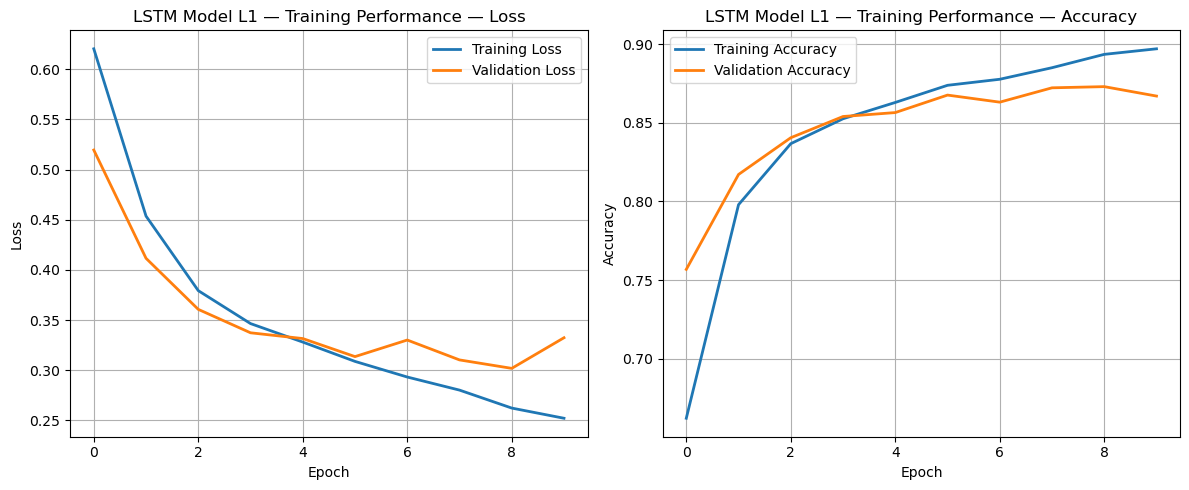

In [8]:


import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# TensorFlow Addons F1 Score
try:
    from tensorflow_addons.metrics import F1Score
    f1_metric = F1Score(num_classes=1, threshold=0.5)
except:
    print("TensorFlow Addons not installed — using accuracy only.")
    f1_metric = None


def build_lstm_model_l1():
    inputs = Input(shape=(seq_len,), name="input_sequence")

    # Shared embedding layer (frozen GloVe)
    x = embedding_layer(inputs)

    # Base Bidirectional LSTM
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    # Regularization
    x = Dropout(0.5)(x)

    # Output layer (binary classification)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="LSTM_L1_Base")
    return model

model_l1 = build_lstm_model_l1()
model_l1.summary()


metrics = ["accuracy"]
if f1_metric is not None:
    metrics.append(f1_metric)

model_l1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=metrics
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


history_l1 = model_l1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


plot_history(history_l1, title="LSTM Model L1 — Training Performance")


Model: "LSTM_L2_Tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_sequence (InputLayer  [(None, 300)]             0         
 )                                                               
                                                                 
 glove_embedding (Embedding  (None, 300, 100)          2000000   
 )                                                               
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                     

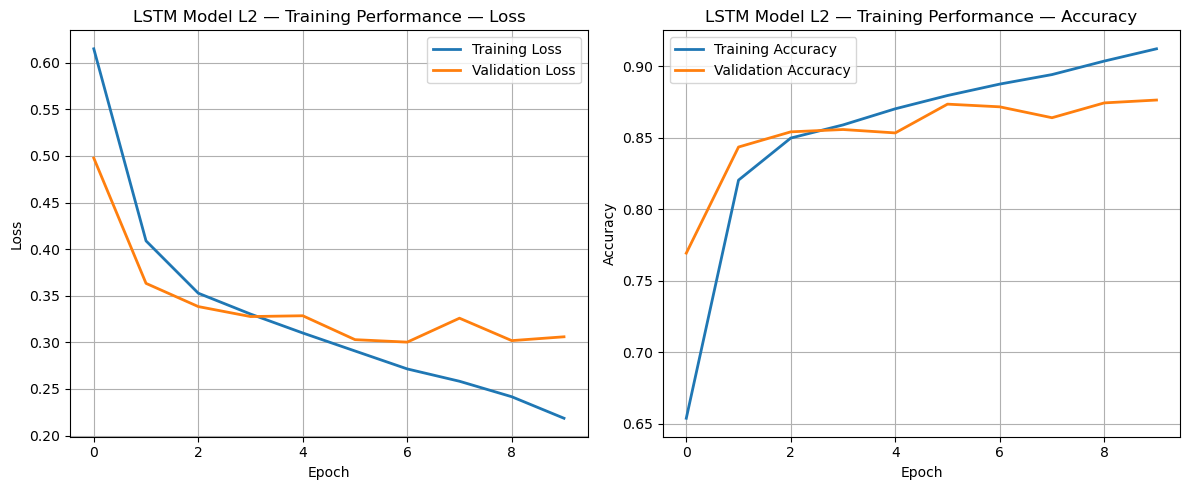

In [9]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model


def build_lstm_model_l2():
    inputs = Input(shape=(seq_len,), name="input_sequence")

    # Shared GloVe embedding layer
    x = embedding_layer(inputs)

    # Tuned Bidirectional LSTM with 128 units
    x = Bidirectional(LSTM(128, return_sequences=False))(x)

    # Regularization
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="LSTM_L2_Tuned")
    return model

model_l2 = build_lstm_model_l2()
model_l2.summary()


metrics = ["accuracy"]
if f1_metric is not None:
    metrics.append(f1_metric)

model_l2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=metrics
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


history_l2 = model_l2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


plot_history(history_l2, title="LSTM Model L2 — Training Performance")


Model: "Transformer_T1_Base"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 glove_embedding (Embedding  (None, 300, 100)             2000000   ['input_sequence[0][0]']      
 )                                                                                                
                                                                                                  
 multi_head_attention (Mult  (None, 300, 100)             161300    ['glove_embedding[2][0]',     
 iHeadAttention)                                                     'glove_embe

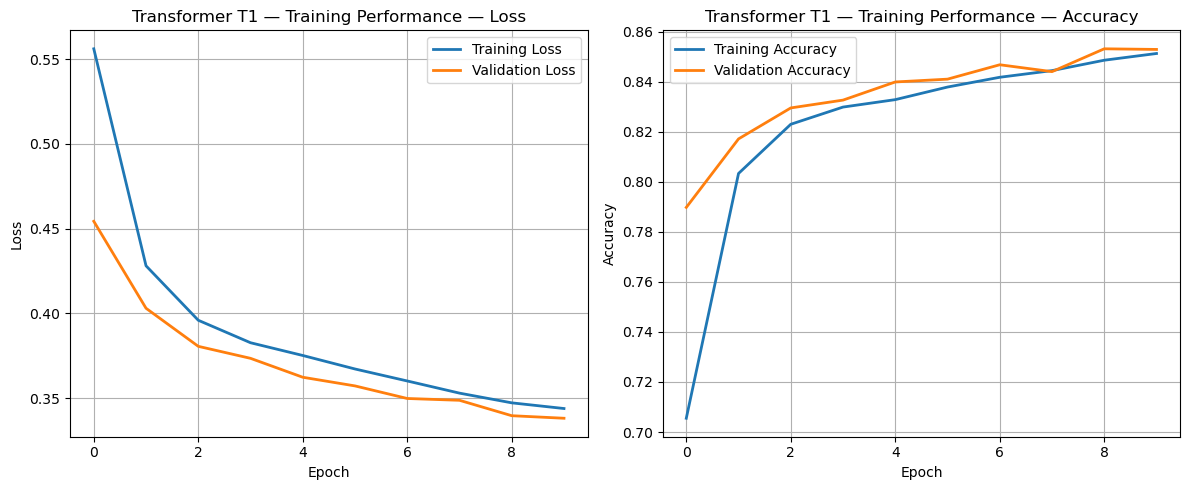

In [10]:

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, GlobalAveragePooling1D,
    Dropout, MultiHeadAttention
)
from tensorflow.keras.models import Model


def transformer_ffn(hidden_dim, ff_dim):
    return tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(hidden_dim)
    ])



def build_transformer_t1(
        num_heads=4,        # baseline: 4 heads
        ff_dim=128,         # baseline FFN dimension
        dropout_rate=0.1    # baseline dropout
    ):

    inputs = Input(shape=(seq_len,), name="input_sequence")

    # ----- Shared frozen GloVe Embedding -----
    x = embedding_layer(inputs)

    # ----- Multi-Head Self-Attention -----
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim
    )(x, x)

    # ----- Add & Norm -----
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    # ----- Feed Forward Network -----
    ffn_output = transformer_ffn(embedding_dim, ff_dim)(x)

    # ----- Add & Norm -----
    x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # ----- Global Pooling -----
    x = GlobalAveragePooling1D()(x)

    # ----- Dropout -----
    x = Dropout(dropout_rate)(x)

    # ----- Dense output (Binary Classification) -----
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="Transformer_T1_Base")
    return model



model_t1 = build_transformer_t1()
model_t1.summary()



metrics = ["accuracy"]
if f1_metric is not None:
    metrics.append(f1_metric)

model_t1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics
)



early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)



history_t1 = model_t1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)



plot_history(history_t1, title="Transformer T1 — Training Performance")


Model: "Transformer_T2_Tuned"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 glove_embedding (Embedding  (None, 300, 100)             2000000   ['input_sequence[0][0]']      
 )                                                                                                
                                                                                                  
 multi_head_attention_1 (Mu  (None, 300, 100)             161300    ['glove_embedding[3][0]',     
 ltiHeadAttention)                                                   'glove_emb

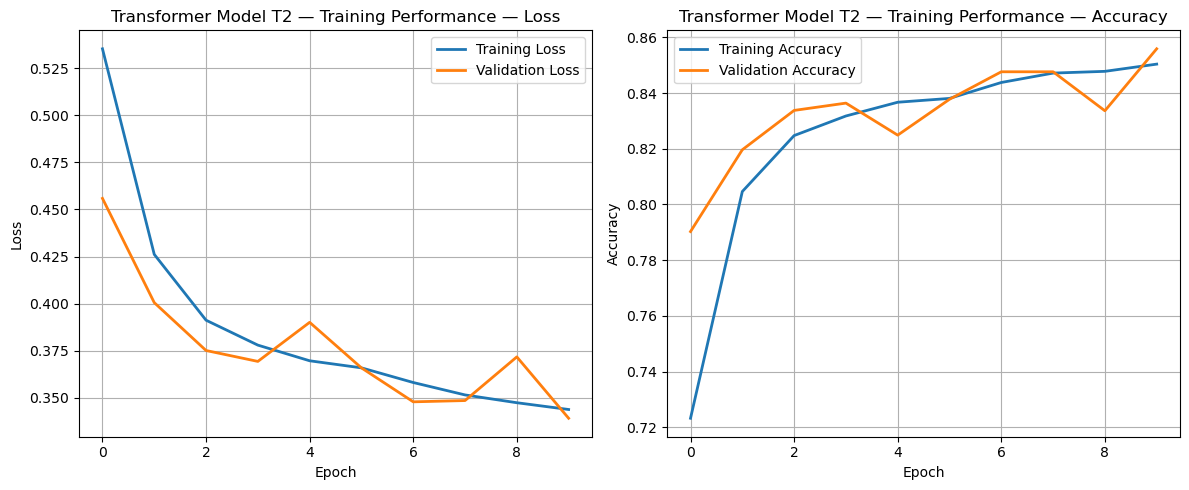

In [11]:

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, GlobalAveragePooling1D,
    Dropout, MultiHeadAttention
)
from tensorflow.keras.models import Model



def transformer_ffn(hidden_dim, ff_dim):
    return tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(hidden_dim)
    ])



def build_transformer_t2(
        num_heads=4,      # same as baseline
        ff_dim=256,       # TUNED: increased from 128 → 256
        dropout_rate=0.1
    ):

    inputs = Input(shape=(seq_len,), name="input_sequence")

    # ----- Shared frozen GloVe Embedding -----
    x = embedding_layer(inputs)

    # ----- Multi-Head Self-Attention -----
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim
    )(x, x)

    # ----- Add & Norm -----
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    # ----- Feed Forward Network (tuned FFN) -----
    ffn_output = transformer_ffn(embedding_dim, ff_dim)(x)

    # ----- Add & Norm -----
    x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # ----- Global Pooling -----
    x = GlobalAveragePooling1D()(x)

    # ----- Dropout -----
    x = Dropout(dropout_rate)(x)

    # ----- Dense output -----
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="Transformer_T2_Tuned")
    return model



model_t2 = build_transformer_t2()
model_t2.summary()



metrics = ["accuracy"]
if f1_metric is not None:
    metrics.append(f1_metric)

model_t2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics
)



early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)



history_t2 = model_t2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)



plot_history(history_t2, title="Transformer Model T2 — Training Performance")


Model: "Transformer_T2_StackedAttention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 glove_embedding (Embedding  (None, 300, 100)             2000000   ['input_sequence[0][0]']      
 )                                                                                                
                                                                                                  
 mha_block_1 (MultiHeadAtte  (None, 300, 100)             161300    ['glove_embedding[4][0]',     
 ntion)                                                             

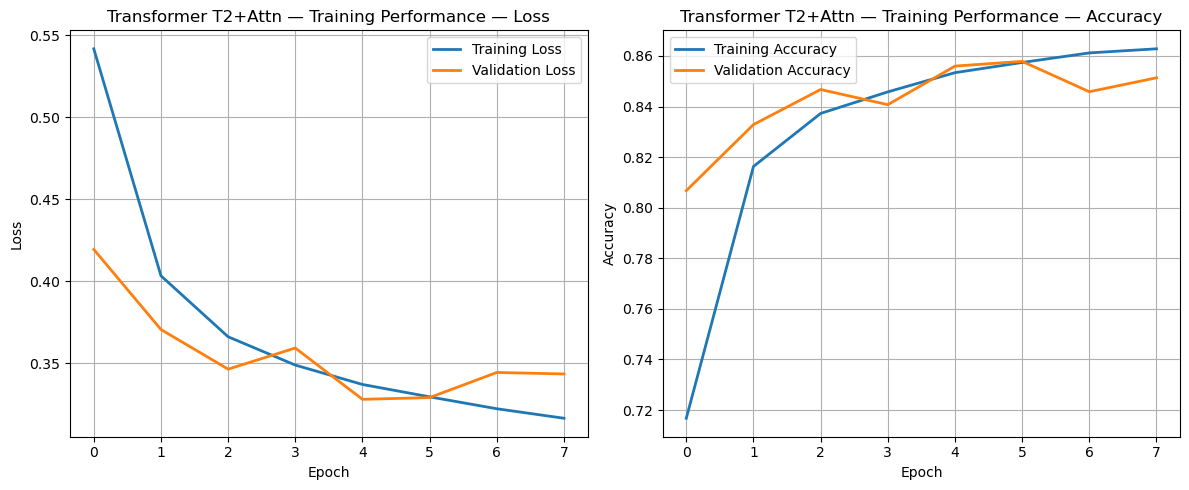

In [12]:

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, GlobalAveragePooling1D,
    Dropout, MultiHeadAttention
)
from tensorflow.keras.models import Model

# Reuse transformer_ffn(hidden_dim, ff_dim) from before



def build_transformer_t2_stacked(
        num_heads=4,      # same as T2
        ff_dim=256,       # same tuned FFN dim as T2
        dropout_rate=0.1
    ):

    inputs = Input(shape=(seq_len,), name="input_sequence")

    # ----- Shared frozen GloVe Embedding -----
    x = embedding_layer(inputs)    # shape: (batch, seq_len, embedding_dim)

    
    attn_output1 = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim,
        name="mha_block_1"
    )(x, x)

    # Add & Norm 1
    x1 = LayerNormalization(epsilon=1e-6, name="ln_1")(x + attn_output1)

    # FFN 1
    ffn_output1 = transformer_ffn(embedding_dim, ff_dim)(x1)

    # Add & Norm 2
    x2 = LayerNormalization(epsilon=1e-6, name="ln_2")(x1 + ffn_output1)

   
    attn_output2 = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim,
        name="mha_block_2"
    )(x2, x2)

    # Add & Norm 3
    x3 = LayerNormalization(epsilon=1e-6, name="ln_3")(x2 + attn_output2)

    # FFN 2 (reuse same FFN dimensions)
    ffn_output2 = transformer_ffn(embedding_dim, ff_dim)(x3)

    # Add & Norm 4
    x4 = LayerNormalization(epsilon=1e-6, name="ln_4")(x3 + ffn_output2)

    # ----- Global Pooling -----
    x_pooled = GlobalAveragePooling1D(name="global_avg_pool")(x4)

    # ----- Dropout -----
    x_out = Dropout(dropout_rate, name="dropout")(x_pooled)

    # ----- Output Layer (binary sentiment) -----
    outputs = Dense(1, activation="sigmoid", name="output")(x_out)

    model = Model(inputs, outputs, name="Transformer_T2_StackedAttention")
    return model



model_t2_attn = build_transformer_t2_stacked()
model_t2_attn.summary()



metrics = ["accuracy"]
if f1_metric is not None:
    metrics.append(f1_metric)

model_t2_attn.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics
)



early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)



history_t2_attn = model_t2_attn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)



plot_history(history_t2_attn, title="Transformer T2+Attn — Training Performance")



Evaluating LSTM L1 (Baseline)...
Accuracy:  0.8675
Precision: 0.9223
Recall:    0.8026
F1-Score:  0.8583


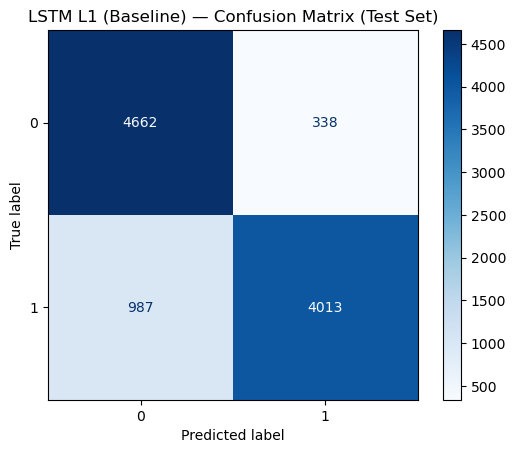


Evaluating LSTM L2 (Tuned)...
Accuracy:  0.8723
Precision: 0.8600
Recall:    0.8894
F1-Score:  0.8744


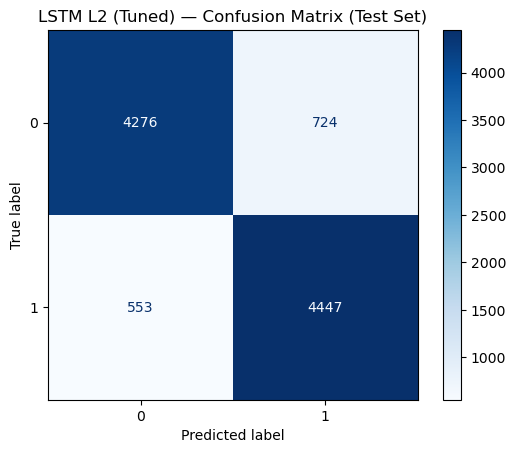


Evaluating Transformer T1 (Baseline)...
Accuracy:  0.8519
Precision: 0.8447
Recall:    0.8624
F1-Score:  0.8534


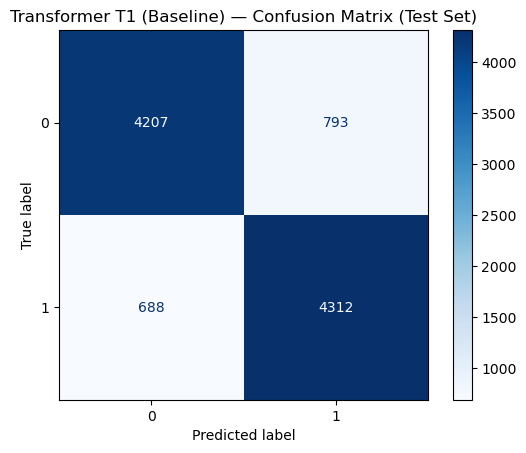


Evaluating Transformer T2 (Tuned)...
Accuracy:  0.8514
Precision: 0.8400
Recall:    0.8682
F1-Score:  0.8539


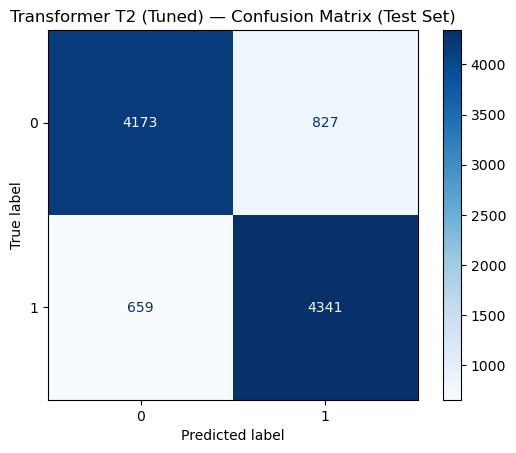


Evaluating Transformer T2+Attn (Stacked Attention)...
Accuracy:  0.8565
Precision: 0.8400
Recall:    0.8808
F1-Score:  0.8599


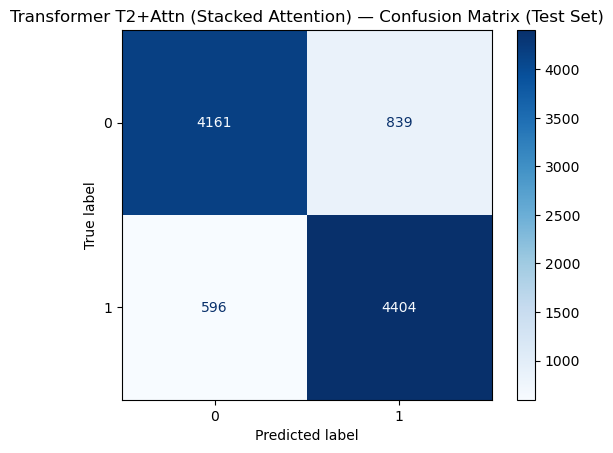

,Model,Accuracy,Precision,Recall,F1
0,LSTM L1 (Baseline),0.8675,0.922317,0.8026,0.858304
1,LSTM L2 (Tuned),0.8723,0.859988,0.8894,0.874447
2,Transformer T1 (Baseline),0.8519,0.844662,0.8624,0.853439
3,Transformer T2 (Tuned),0.8514,0.839977,0.8682,0.853855
4,Transformer T2+Attn (Stacked Attention),0.8565,0.839977,0.8808,0.859904


In [13]:

import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt



def evaluate_model(model, model_name):
    print(f"\nEvaluating {model_name}...")
    
    # Predict probabilities
    y_pred_prob = model.predict(X_test, verbose=0)
    
    # Convert to binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Compute metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    # Print metrics
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} — Confusion Matrix (Test Set)")
    plt.show()

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }



results = []

results.append(evaluate_model(model_l1,       "LSTM L1 (Baseline)"))
results.append(evaluate_model(model_l2,       "LSTM L2 (Tuned)"))
results.append(evaluate_model(model_t1,       "Transformer T1 (Baseline)"))
results.append(evaluate_model(model_t2,       "Transformer T2 (Tuned)"))
results.append(evaluate_model(model_t2_attn,  "Transformer T2+Attn (Stacked Attention)"))


import pandas as pd

results_df = pd.DataFrame(results)
results_df


Across all five models, the tuned LSTM achieved the strongest overall performance, producing the highest F1 score and outperforming every other architecture on the held-out test set. The baseline LSTM also performed competitively, reinforcing the idea that recurrent networks, especially when paired with pretrained GloVe embeddings, are well-suited for many-to-one sentiment classification tasks. In comparison, the Transformer-based models showed solid but slightly lower accuracy and F1 scores. The baseline Transformer behaved as expected, and increasing the feed-forward network dimension produced only a modest improvement. Introducing a second stacked multi-head attention layer further stabilized the Transformer and improved recall, bringing its performance closer to the LSTM models, although it still did not surpass the tuned LSTM. Overall, these findings align with theoretical expectations: LSTMs excel at modeling sequential sentiment cues in datasets of this size, while lightweight Transformers without positional encodings or large-scale pretraining typically underperform. Thus, the tuned LSTM stands out as the superior model for this task, with the stacked-attention Transformer representing the strongest non-recurrent alternative.

# 3. Exceptional Work

# 4. Citation